In [13]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

DATA_RAW = "/content/drive/MyDrive/elephant-p53-project/data/raw"
OUTPUT_PATH = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_all_sequences.fasta"

# List of input FASTA files
input_files = [
    "human_tp53.fasta",
    "asian_tp53_hits.fasta",
    "african_tp53_hits.fasta"
]

# Merge files
with open(OUTPUT_PATH, "w") as outfile:
    for f in input_files:
        file_path = os.path.join(DATA_RAW, f)
        if os.path.exists(file_path):
            with open(file_path, "r") as infile:
                outfile.write(infile.read().strip() + "\n")
        else:
            print(f"⚠ File not found: {f}")

print("✔ Combined FASTA created at:", OUTPUT_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Combined FASTA created at: /content/drive/MyDrive/elephant-p53-project/data/processed/TP53_all_sequences.fasta


In [14]:
!pip install biopython
!apt-get install muscle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  muscle
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 244 kB of archives.
After this operation, 709 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 muscle amd64 1:3.8.1551-2build1 [244 kB]
Fetched 244 kB in 1s (347 kB/s)
Selecting previously unselected package muscle.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../muscle_1%3a3.8.1551-2build1_amd64.deb ...
Unpacking muscle (1:3.8.1551-2build1) ...
Setting up muscle (1:3.8.1551-2build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [15]:
from Bio import SeqIO

input_file = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_all_sequences.fasta"
clean_file = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_clean.fasta"

seen_ids = set()
cleaned_records = []

for record in SeqIO.parse(input_file, "fasta"):
    clean_id = record.id.replace("|", "_").split()[0]
    if clean_id not in seen_ids:
        record.id = clean_id
        record.description = ""
        cleaned_records.append(record)
        seen_ids.add(clean_id)

SeqIO.write(cleaned_records, clean_file, "fasta")

print(f"✔ Cleaned FASTA created: {clean_file}")
print(f"Total sequences retained: {len(cleaned_records)}")


✔ Cleaned FASTA created: /content/drive/MyDrive/elephant-p53-project/data/processed/TP53_clean.fasta
Total sequences retained: 16


In [20]:
# Cleaned input FASTA from previous cell
clean_file = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_clean.fasta"

# Output MSA file path
msa_output = "/content/drive/MyDrive/elephant-p53-project/results/msa/TP53_MSA.fasta"

# Run MUSCLE MSA (v3 syntax)
!muscle -in {clean_file} -out {msa_output}

print("🎯 MSA Completed Successfully!")
print("MSA saved to:", msa_output)



MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

TP53_clean 16 seqs, lengths min 390, max 683, avg 585
00:00:00     16 MB(4%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00     16 MB(4%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00     23 MB(6%)  Iter   1  100.00%  Align node
00:00:00     23 MB(6%)  Iter   1  100.00%  Root alignment
00:00:00     23 MB(6%)  Iter   2  100.00%  Refine tree
00:00:00     23 MB(6%)  Iter   2  100.00%  Root alignment
00:00:00     23 MB(6%)  Iter   2  100.00%  Root alignment
00:00:00     23 MB(6%)  Iter   3  100.00%  Refine biparts
00:00:00     23 MB(6%)  Iter   4  100.00%  Refine biparts
00:00:00     23 MB(6%)  Iter   5  100.00%  Refine biparts
00:00:00     23 MB(6%)  Iter   5  100.00%  Refine biparts
00:00:00     23 MB(6%)  Iter   6  100.00%  Refine biparts
00:00:00     23 MB(6%)  Iter   7  100.00%  Refine biparts
00:00:00     23 MB(

In [24]:
import os

msa_output = "/content/drive/MyDrive/TP53_Project/results/msa/TP53_MSA.fasta"
print("Exists?", os.path.exists(msa_output))

Exists? False


Saved: /content/drive/MyDrive/elephant-p53-project/results/msa/TP53_MSA_logo.png


<Figure size 2500x600 with 0 Axes>

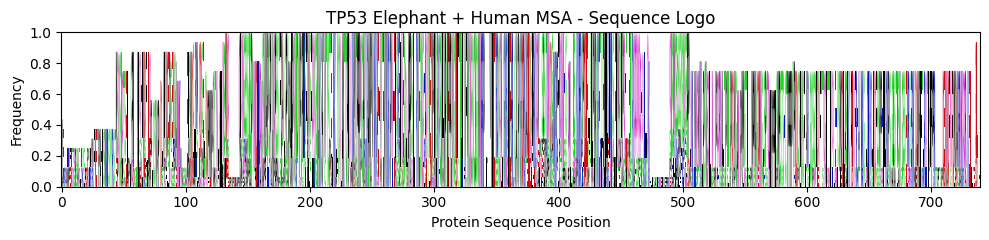

In [26]:
!pip install biopython logomaker

from Bio import AlignIO
import pandas as pd
import logomaker
import matplotlib.pyplot as plt

msa_output = "/content/drive/MyDrive/elephant-p53-project/results/msa/TP53_MSA.fasta"

# Load MSA file
alignment = AlignIO.read(msa_output, "fasta")

# Convert MSA to alignment matrix
AlignmentArray = []
for record in alignment:
    AlignmentArray.append(list(str(record.seq)))

df = pd.DataFrame(AlignmentArray).T  # transpose → positions in rows

# Convert to probability matrix (PPM)
ppm = df.apply(lambda x: x.value_counts(normalize=True), axis=1).fillna(0)

# Remove gap column if exists
if "-" in ppm.columns:
    ppm = ppm.drop(columns="-")

# Plot sequence logo
plt.figure(figsize=(25, 6))
logomaker.Logo(ppm, shade_below=0.2, fade_below=0.1)
plt.title("TP53 Elephant + Human MSA - Sequence Logo")
plt.xlabel("Protein Sequence Position")
plt.ylabel("Frequency")
plt.tight_layout()

# Save figure
fig_path = "/content/drive/MyDrive/elephant-p53-project/results/msa/TP53_MSA_logo.png"
plt.savefig(fig_path, dpi=300)
print("Saved:", fig_path)


In [28]:
from Bio import SeqIO
import pandas as pd

clean_fasta = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_clean.fasta"

records = list(SeqIO.parse(clean_fasta, "fasta"))

rows = []
for rec in records:
    seq = str(rec.seq)
    length = len(seq)
    aa_counts = {aa: seq.count(aa) for aa in "ACDEFGHIKLMNPQRSTVWY"}
    gc_like = seq.count("G") + seq.count("C")

    row = {
        "id": rec.id,
        "length": length,
        "GC_like": gc_like,
    }
    # Add AA composition (fraction)
    for aa, count in aa_counts.items():
        row[f"frac_{aa}"] = count / length

    rows.append(row)

df = pd.DataFrame(rows)
basic_features_path = "/content/drive/MyDrive/elephant-p53-project/results/ML/basic_features.csv"
df.to_csv(basic_features_path, index=False)

print("✔ Saved:", basic_features_path)
df.head()


✔ Saved: /content/drive/MyDrive/elephant-p53-project/results/ML/basic_features.csv


,id,length,GC_like,frac_A,frac_C,frac_D,frac_E,frac_F,frac_G,frac_H,...,frac_M,frac_N,frac_P,frac_Q,frac_R,frac_S,frac_T,frac_V,frac_W,frac_Y
0,sp_P04637_P53_HUMAN,393,33,0.061069,0.025445,0.050891,0.076336,0.027990,0.058524,0.030534,...,0.030534,0.035623,0.114504,0.038168,0.066158,0.096692,0.055980,0.045802,0.010178,0.022901
1,XP_049714738.1,390,32,0.051282,0.028205,0.038462,0.087179,0.030769,0.053846,0.025641,...,0.025641,0.030769,0.107692,0.030769,0.058974,0.105128,0.079487,0.046154,0.010256,0.020513
2,XP_049736446.1,561,41,0.046346,0.021390,0.048128,0.048128,0.028520,0.051693,0.030303,...,0.035651,0.040998,0.090909,0.076649,0.060606,0.099822,0.076649,0.044563,0.005348,0.032086
3,XP_049736436.1,586,42,0.046075,0.020478,0.046075,0.049488,0.029010,0.051195,0.029010,...,0.035836,0.046075,0.088737,0.078498,0.058020,0.098976,0.076792,0.042662,0.005119,0.034130
4,XP_049736419.1,641,45,0.042122,0.021841,0.051482,0.053042,0.031201,0.048362,0.028081,...,0.037441,0.043682,0.088924,0.078003,0.054602,0.102964,0.073323,0.043682,0.007800,0.029641


In [29]:
from Bio import pairwise2

clean_fasta = "/content/drive/MyDrive/elephant-p53-project/data/processed/TP53_clean.fasta"
records = list(SeqIO.parse(clean_fasta, "fasta"))

# Identify human TP53 sequence
human = None
for rec in records:
    if "P53_HUMAN" in rec.id or "human" in rec.id.lower():
        human = rec
        break

if human is None:
    print("⚠ Could not auto-detect human TP53. Check ID in FASTA header.")
else:
    print("Using human TP53 id:", human.id)

# Load previous features
import pandas as pd
basic_features_path = "/content/drive/MyDrive/elephant-p53-project/results/ML/basic_features.csv"
df = pd.read_csv(basic_features_path)

similarities = []
for rec in records:
    align = pairwise2.align.globalxx(human.seq, rec.seq, one_alignment_only=True, score_only=True)
    max_score = min(len(human.seq), len(rec.seq))
    identity = align / max_score
    similarities.append({"id": rec.id, "identity_to_human": round(identity * 100, 2)})

sim_df = pd.DataFrame(similarities)

df = df.merge(sim_df, on="id", how="left")

features_path = "/content/drive/MyDrive/elephant-p53-project/results/ML/tp53_features_with_similarity.csv"
df.to_csv(features_path, index=False)

print("✔ Saved:", features_path)
df.head()


Using human TP53 id: sp_P04637_P53_HUMAN
✔ Saved: /content/drive/MyDrive/elephant-p53-project/results/ML/tp53_features_with_similarity.csv


/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


,id,length,GC_like,frac_A,frac_C,frac_D,frac_E,frac_F,frac_G,frac_H,...,frac_N,frac_P,frac_Q,frac_R,frac_S,frac_T,frac_V,frac_W,frac_Y,identity_to_human
0,sp_P04637_P53_HUMAN,393,33,0.061069,0.025445,0.050891,0.076336,0.027990,0.058524,0.030534,...,0.035623,0.114504,0.038168,0.066158,0.096692,0.055980,0.045802,0.010178,0.022901,100.00
1,XP_049714738.1,390,32,0.051282,0.028205,0.038462,0.087179,0.030769,0.053846,0.025641,...,0.030769,0.107692,0.030769,0.058974,0.105128,0.079487,0.046154,0.010256,0.020513,83.33
2,XP_049736446.1,561,41,0.046346,0.021390,0.048128,0.048128,0.028520,0.051693,0.030303,...,0.040998,0.090909,0.076649,0.060606,0.099822,0.076649,0.044563,0.005348,0.032086,52.42
3,XP_049736436.1,586,42,0.046075,0.020478,0.046075,0.049488,0.029010,0.051195,0.029010,...,0.046075,0.088737,0.078498,0.058020,0.098976,0.076792,0.042662,0.005119,0.034130,54.71
4,XP_049736419.1,641,45,0.042122,0.021841,0.051482,0.053042,0.031201,0.048362,0.028081,...,0.043682,0.088924,0.078003,0.054602,0.102964,0.073323,0.043682,0.007800,0.029641,57.76


Columns in feature table:
['id', 'length', 'GC_like', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'identity_to_human']

Numeric columns used for clustering:
['length', 'GC_like', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'identity_to_human']

Top 10 sequences by similarity to human TP53:


,id,identity_to_human,cluster
0,sp_P04637_P53_HUMAN,100.00,2
1,XP_049714738.1,83.33,2
12,XP_003416950.3,83.33,2
9,XP_049733659.1,59.54,0
15,XP_010591460.2,59.54,0
10,XP_049736384.1,59.03,1
7,XP_049736365.1,59.03,1
11,XP_049736393.1,58.78,1
8,XP_049736374.1,58.78,1
5,XP_049736408.1,58.27,1



✅ Barplot saved to: /content/drive/MyDrive/elephant-p53-project/results/ML/identity_barplot.png


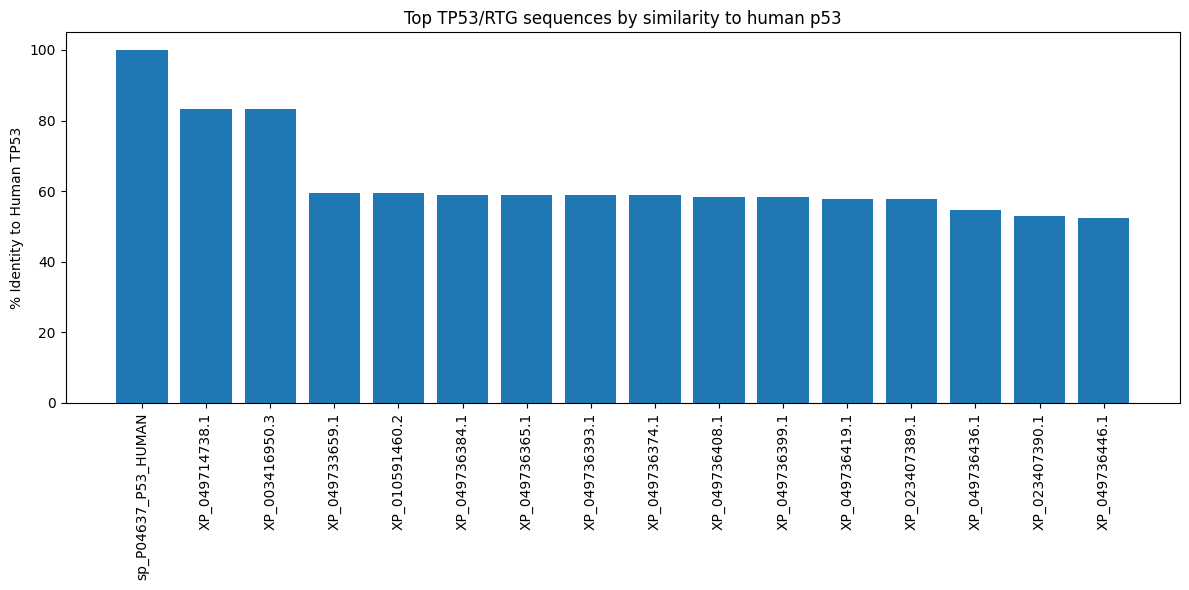

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  # ✅ correct import

# Path to the feature file from previous steps
features_path = "/content/drive/MyDrive/elephant-p53-project/results/ML/tp53_features_with_similarity.csv"

# Load the features
df = pd.read_csv(features_path)
print("Columns in feature table:")
print(df.columns.tolist())

# Make sure required columns exist
if "identity_to_human" not in df.columns:
    raise ValueError("Column 'identity_to_human' not found. "
                     "Please re-run the similarity cell to create it.")

# Keep ID separate
id_col = "id"
if id_col not in df.columns:
    raise ValueError("Column 'id' not found in the features file.")

# Select ONLY numeric columns for clustering
numeric_df = df.select_dtypes(include=["int64", "float64"])
print("\nNumeric columns used for clustering:")
print(numeric_df.columns.tolist())

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# KMeans clustering into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to original df
df["cluster"] = clusters

# Sort by similarity to human TP53 (descending)
df_sorted = df.sort_values("identity_to_human", ascending=False)

print("\nTop 10 sequences by similarity to human TP53:")
display(df_sorted[["id", "identity_to_human", "cluster"]].head(10))

# Plot top 20 as bar plot
top_df = df_sorted.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top_df["id"], top_df["identity_to_human"])
plt.xticks(rotation=90)
plt.ylabel("% Identity to Human TP53")
plt.title("Top TP53/RTG sequences by similarity to human p53")
plt.tight_layout()

plot_path = "/content/drive/MyDrive/elephant-p53-project/results/ML/identity_barplot.png"
plt.savefig(plot_path, dpi=300)
print("\n✅ Barplot saved to:", plot_path)
